In [1]:
import geopandas as gpd
import contextily as cx
from shapely.geometry import LineString

from data.constants import (WEB_CRS)
from viz import plot_lines, plot_points
import plotly.express as px

import geopandas as gpd

from data.constants import (DATA_FOLDER, LOCAL_CRS, WORLD_CRS, WEB_CRS)

In [2]:
bike_stations_file_in = "../../data/raw/bike_stations.geojson"
bike_stations = gpd.read_file(bike_stations_file_in)

In [3]:
bike_rides_in = "../../data/deprecated/bike_rides.geoparquet"
bike_rides = gpd.read_parquet(bike_rides_in)
bike_rides_in = "../../data/deprecated/bike_rides_v2.geoparquet"
bike_rides_spatial = gpd.read_parquet(bike_rides_in)

# Id Bijectiveness

<Axes: xlabel='name'>

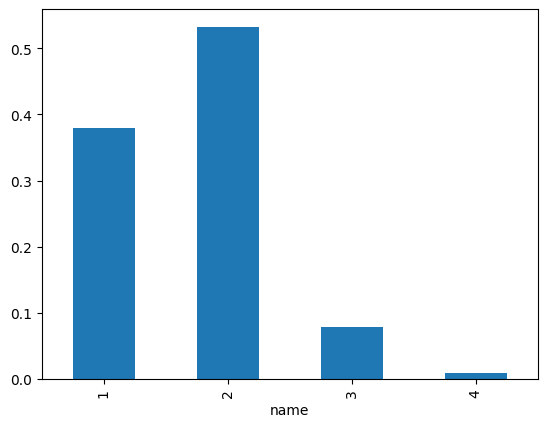

In [4]:
nnames = bike_stations.groupby(['station_id'])['name'].transform('nunique')
nnames.value_counts(normalize=True).sort_index().plot(kind='bar')

In [5]:
suspicious = bike_stations[nnames == nnames.max()]
suspicious.sort_values(['station_id','name'])[['station_id','name','vintage']]
# So it looks like ids are stable within vintages but not across.

,station_id,name,vintage
346,53.0,Green St & Randolph St,Divvy_Stations_Trips_2014_Q1Q2.zip
3120,53.0,LaSalle (Wells) St & Huron St,Divvy_Trips_2017_Q3Q4.zip
36,53.0,Wells St & Erie St,Divvy_Stations_Trips_2013.zip
635,53.0,Wells St & Erie St,Divvy_Stations_Trips_2014_Q3Q4.zip
948,53.0,Wells St & Erie St,Divvy_Trips_2015-Q1Q2.zip
1860,53.0,Wells St & Huron St,Divvy_Trips_2016_Q1Q2.zip
2452,53.0,Wells St & Huron St,Divvy_Trips_2016_Q3Q4.zip
3013,53.0,Wells St & Huron St,Divvy_Trips_2017_Q1Q2.zip
2493,80.0,Aberdeen St & Madison (Monroe) St,Divvy_Trips_2017_Q1Q2.zip
57,80.0,Aberdeen St & Madison St,Divvy_Stations_Trips_2013.zip


In [6]:
point_plot_data = suspicious.drop_duplicates().assign(lon=suspicious.geometry.x, 
                                                lat=suspicious.geometry.y,
                                                station_id=suspicious.station_id.astype(str))
line_plot_data = (point_plot_data
                  .groupby('station_id',as_index=False)['geometry']
                  .apply(lambda x: LineString(x))
                  .set_crs(point_plot_data.crs))
traces = {}
fig1 = px.scatter_map(point_plot_data.to_crs(WEB_CRS),
                      lon='lon',lat='lat',color='station_id',
                      hover_name='name', hover_data={'lon':False, 'lat':False, 'station_id':False, 'vintage':True})
# fig2 = plot_lines(line_plot_data, color_col="station_id")
# fig3 = fig1.add_traces(fig2.data)
fig1.write_json("../../reports/replication/bike-id-name.json")
fig1.show()
# TODO: can't figure out how to get both lines and points on same map.

# Name Bijectiveness

In [7]:
# Visualize where these points are
point_plot_data = (bike_stations[(bike_stations['name']=="Buckingham Fountain")]
                    .assign(lon=lambda x: x['geometry'].x,
                            lat=lambda x: x['geometry'].y))
fig = px.scatter_map(point_plot_data.to_crs(WEB_CRS),
                      lon='lon',lat='lat',
                      hover_name='name', hover_data={'lon':False, 'lat':False, 'station_id':False, 'vintage':True})
fig.write_json("../../reports/replication/buckingham.json")
fig.show()

# Attribute Clustering

In [8]:
import pandas as pd
clusterable = bike_rides.groupby(['station_id','station_name','vintage'])['station_cluster_id'].transform('nunique') == 1
non_clusterable = bike_rides[~clusterable]
clusterable = bike_rides[clusterable]
sample_clusterable = clusterable[['station_id','station_name','vintage']].drop_duplicates().sample(5)
sample_nonclusterable = non_clusterable[['station_id','station_name','vintage']].drop_duplicates().sample(5)
sample_clusterable = sample_clusterable.merge(clusterable, how='left')
sample_nonclusterable = sample_nonclusterable.merge(non_clusterable, how='left')
sample = pd.concat([sample_clusterable, sample_nonclusterable], keys=[True, False], names=['clustered','index']).reset_index()

In [9]:
plot_data = sample.assign(lat = gpd.GeoSeries(sample.geometry).y, 
                          lon=gpd.GeoSeries(sample.geometry).x,
                          marker=sample['clustered'].map({True: 'square', False: 'circle'}))
fig = px.scatter_map(plot_data, lat='lat', lon='lon', 
                     color='station_name')
fig.write_json("../../reports/replication/bike-clusters.json")
fig.show()

# Spatial Clustering

In [10]:
bike_rides = bike_rides_spatial

In [11]:
((bike_rides['station_cluster_centroid']==bike_rides['super_centroid']).mean(),
(bike_rides.groupby('station_cluster_id')['super_centroid'].transform('nunique') == 1).all(),
(bike_rides.groupby('super_centroid')['station_cluster_id'].transform('nunique') == 1).mean(),
(bike_rides.groupby('super_centroid')['station_cluster_id'].nunique() == 1).mean())
# Very few centroids are exactly equal to their super cluster.
# Station cluster -> super cluster is at least m:1.
# Station cluster -> super cluster is 1:1 in 15% of rows 
# Station cluster -> super cluster is 1:1 in 78% of super clusters 
# This basically affirms that attribute clustering worked.

(np.float64(0.019009432442261394),
 np.True_,
 np.float64(0.1925939906734368),
 np.float64(0.8189409368635437))

In [12]:
# Distribution of cluster sizes
is_one_to_many = bike_rides.groupby('super_centroid')['station_cluster_id'].transform('nunique')>1
print(f"{1-is_one_to_many.mean():.2%} of points are in single-point clusters")
px.box(bike_rides.groupby('super_centroid')['station_cluster_id'].nunique())

19.26% of points are in single-point clusters


In [13]:
# Find median of distribution in terms of number of points
plot_data = bike_rides.groupby('super_centroid')['station_cluster_id'].nunique().value_counts().reset_index()
plot_data.columns = ['num_points_per_cluster', 'num_clusters']
plot_data['num_points'] = plot_data['num_points_per_cluster'] * plot_data['num_clusters']
plot_data = plot_data.sort_values('num_points_per_cluster')
plot_data['cum_pct'] = plot_data['num_points'].cumsum() / plot_data['num_points'].sum()
plot_data.iloc[plot_data['cum_pct'].searchsorted(.5)] # 2404

num_points_per_cluster    2404.000000
num_clusters                 1.000000
num_points                2404.000000
cum_pct                      0.500184
Name: 248, dtype: float64

In [14]:
def plot_points_centroids(gdf):
    fig1 = plot_points(gdf.drop_duplicates('station_cluster_centroid'), 'station_cluster_centroid')
    fig2 = plot_points(gdf.drop_duplicates('super_centroid'), 'super_centroid')

    fig1.update_traces(marker=dict(color="red"), name="Original Points")
    fig2.update_traces(marker=dict(color="blue"), name="Centroids")

    for trace in fig2.data:
        fig1.add_trace(trace)
    return fig1


In [15]:
# Plot some relatively small clusters
sizes = bike_rides.groupby('super_centroid')['station_cluster_id'].transform('nunique')
is_one_to_few = (sizes > 1) & (sizes <= 2404)
is_one_to_many = sizes > 2024

sample = bike_rides[is_one_to_few].super_centroid.sample(10)
plot_data = bike_rides[is_one_to_few & bike_rides.super_centroid.isin(sample)]
fig = plot_points_centroids(plot_data)
fig.show()
# These are nicely spaced out.

In [ ]:
# Instead of plotting all one-to-many points, take the worst set, which are downtown. 
# And only sample a few thousand just for illustration.
comms = gpd.read_file("../../data/interim/communities.geojson")
downtown = comms.loc[comms.area_num_1.isin(['32', '33', '28', '8'])].to_crs(LOCAL_CRS).geometry.union_all()
plot_data = bike_rides[is_one_to_many & bike_rides.to_crs(LOCAL_CRS).within(downtown)].sample(5000)
fig = plot_points_centroids(plot_data)
fig.write_json("../../reports/replication/bike-spatial-cluster.json")
fig.show()

In [ ]:
# Instead of plotting all one-to-many points, take the worst set, which are downtown. 
# And only sample a few thousand just for illustration.
plot_data = bike_rides[is_one_to_many & bike_rides.to_crs(LOCAL_CRS).within(downtown)].sample(10000)
fig = plot_points(plot_data, color='station_name')
fig.write_json("../../reports/replication/bike-spatial-cluster.json")
fig.show()